# Logistic Regression and SGD Homework 
***
**Name**: $<$Xiaolan Cai$>$ 
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [4]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [44]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        #print(self.x)
        #print(self.nonzero)
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [45]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)



[1] The number of words in vocabulary is : 5327

[2] Bag-of-words, because the frequency of each word in the vocab is counted

[3] lable 0 refers to automobiles, lable 1 refers to motorcycles



### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [34]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()
 

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        
        # TODO implement LSR updates of weights 
        x = train_example.x
        y = train_example.y
        shrinkage = 1 - 2*self.lam * self.eta
        

        if self.lam == 0:
            #calculate sigmoid with updated w
            smii = self.sigmoid(np.dot(np.transpose(self.w),x)) - y
            for kk in range(len(self.w)):
                if x[kk] != 0:
                    self.w[kk] -= self.eta * smii * x[kk]

            
        elif self.lam > 0 :
                    
            smii = self.sigmoid(np.dot(np.transpose(self.w),x)) - y
            
            if iteration == 0:
                
                for i in range(len(x)):
                    self.last_update.update({i:-1})
                
                for kk in range(len(self.w)):
                    if x[kk] != 0:
                        self.w[kk] -= self.eta * smii * x[kk] 
                        self.last_update[kk] = iteration

                        if kk > 0:
                            self.w[kk] *= shrinkage
                                                        
                            
            if iteration > 0:                            
                for jj in range(len(self.w)):
                    if x[jj] != 0:
                        self.w[jj] -= smii * x[jj]  
                        
                        if jj >0:
                            m = iteration - self.last_update.get(jj)
                            self.w[jj] *= (shrinkage ** m)
                            self.last_update[jj] = iteration
                                    

In [35]:
lr = LogReg(train_set, test_set, lam=0.25, eta=1)
lr.train(isVerbose=False)


The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [46]:
#print(lr.test_acc)
    


In [31]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [32]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

In [48]:
lam_l= np.arange(0.0,1.0,0.1)
acc = []
for i in lam_l:
    lr = LogReg(train_set, test_set, lam=i, eta = 1)
    lr.train()
    acc.append(max(lr.test_acc))

print(acc)

[0.9482758620689655, 0.7758620689655172, 0.7931034482758621, 0.7586206896551724, 0.6982758620689655, 0.5344827586206896, 0.6724137931034483, 0.6724137931034483, 0.646551724137931, 0.6896551724137931]


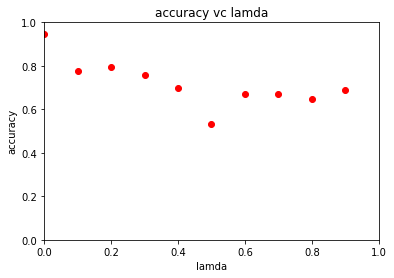

In [95]:
plt.plot(lam_l, acc, 'ro')
plt.axis([0, 1.0, 0, 1.0])
plt.title("accuracy vc lamda")
plt.xlabel("lamda")
plt.ylabel("accuracy")
plt.show()

Below plot is the relation of lam and accuracy of classifier on test set. As we can see, when lam=0, the accuracy result seems the best. 
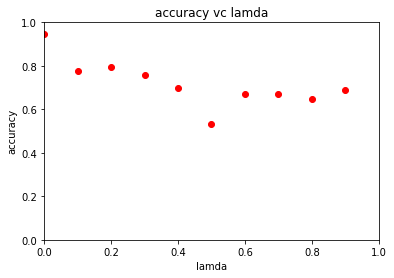

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

In [99]:
theta = np.arange(0.1,1.1,0.2)
acc2 = []
acc_max = []
for i in theta:
    lr = LogReg(train_set, test_set, lam=0, eta=i)
    lr.train()
    acc2.append(lr.test_acc)
    acc_max.append(np.average(lr.test_acc))



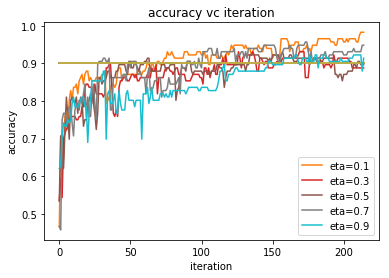

In [101]:
for i in range (len(acc2)):
    x = range(len(lr.test_acc))
    y = acc2[i]

    plt.plot(x,[0.9]*len(lr.test_acc))
    plt.plot(x,y,label="eta=0.%d"%(2*i+1))
    plt.title("accuracy vc iteration")
    plt.xlabel("iteration")
    plt.ylabel("accuracy")
    plt.legend()

Below plot is the relation of accuracy and iteration. As we can see, when eta =0.1, it converges the fastest, and when eta =0.3, it is also fast. However, the accuracy of test set is the highest when eta =0.1. Combining these two facts, the learning rate of 0.1 is a good rate.
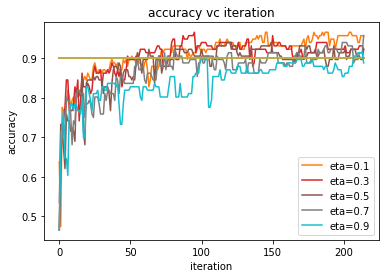

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [137]:
lr = LogReg(train_set, test_set, lam=0, eta = 0.1)
lr.train()
w_dict = {}
for i in range(len(vocab)):
    w_dict.update({vocab[i]:lr.w[i]})

sort_d = sorted(w_dict.values())
neg = sort_d[0:10]
pos = sort_d[-10:]

for i in range(10):
    
    negword = list(w_dict.keys())[list(w_dict.values()).index(neg[i])]

    print(negword)
    print(w_dict[negword])


for i in range(10):
    
    posword = list(w_dict.keys())[list(w_dict.values()).index(pos[i])]
    print(posword)
    print(w_dict[posword])
    


car
-1.83110173723
school
-1.1480475995
list
-1.11391526787
cars
-0.973677863343
price
-0.824224472698
spring
-0.806567522356
welty
-0.775448933815
request
-0.738112528076
acs
-0.697450641746
andrew
-0.693915890755
parking
0.708448217032
moa
0.712370581855
jonathan
0.876283444807
riding
0.952744265133
helmet
0.955146758184
rider
0.996085383546
ride
1.13113610007
bikes
1.21515457215
bike
1.94299604747
dod
2.11672207852


The way to identify the best predictors for each class is to sort according to the weight of each word. If the weight is negative, it means the word contributes in predicting the negative class which is the motorcyle class. If the weight is positive, it means the word contribute in predicting the positive class which is the motorcyle class. The bigger absolute value of the weight, the better prediction it makes to each class.

The top 10 words that are best predictors for predicting automobiles(class 0):

car 
-1.83110173723

school
-1.1480475995

list
-1.11391526787

cars
-0.973677863343

price
-0.824224472698

spring
-0.806567522356

welty
-0.775448933815

request
-0.738112528076

acs
-0.697450641746

andrew
-0.693915890755


The top 10 words that are best predictors for prediction motorcycles(class 1):

parking
0.708448217032

moa
0.712370581855

jonathan
0.876283444807

riding
0.952744265133

helmet
0.955146758184

rider
0.996085383546

ride
1.13113610007

bikes
1.21515457215

bike
1.94299604747

dod
2.11672207852

**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [153]:

sort_abs = sorted(sort_d,key=abs)
#print(sort_abs)

worst_w = sort_abs[0:11]

for i in range(11):
    
    worstword = list(w_dict.keys())[list(w_dict.values()).index(worst_w[i])]

    print(worstword)
    print(w_dict[worstword])

    


differently
-2.06115354421e-10
differently
-2.06115354421e-10
obey
-4.12230723638e-10
goodyear
-8.24461447276e-10
predictable
-1.75401200212e-09
comprising
-2.10319930342e-09
fences
-2.30931466524e-09
disciplined
-2.51543002706e-09
similarly
-3.02400927786e-09
aging
-4.24081416351e-09
traded
-3.26742404765e-08


'\n\n# put weight>=0 in a list\npos = []\n#weight <0 in a list\nneg = []\n\nfor i in range(len(sort_d)):\n    if sort_d[i] >=0:\n        pos.append(sort_d[i])\n    elif sort_d[i] < 0:\n        neg.append(sort_d[i])\n        \npos = pos[0:10]\nneg = neg[-10:]\n\nprint(pos)\nprint(neg)\n'

The way to identify the worst words in predicting class is to find the words whose weights are closest to zero. That is to sort the weight by the absolute value and take the smallest 10 weight values. Because if the weight is very close to zero, the word contributes very little for this class. 


The top 10 worst words in predicting class are listed follows:

differently
-2.06115354421e-10

obey
-4.12230723638e-10

goodyear
-8.24461447276e-10

predictable
-1.75401200212e-09

comprising
-2.10319930342e-09

fences
-2.30931466524e-09

disciplined
-2.51543002706e-09

similarly
-3.02400927786e-09

aging
-4.24081416351e-09

traded
-3.26742404765e-08